In [1]:
from pandas import DataFrame, read_csv
import matplotlib.pyplot as plt
import pandas as pd #this is how I usually import pandas
import sys #only needed to determine Python version number
import matplotlib #only needed to determine Matplotlib version number
%matplotlib inline

In [3]:
months = ['\\april','\\febrouary','\march']
files = ['\listings.csv','\listings0.csv']
# inputPath= r"C:\Users\myrto\Desktop\data"
inputPath= r"C:\Users\nikol\Desktop\dataMining_p1\data\data"
columnlist = ['id','zipcode','transit','bedrooms','beds','review_scores_rating','number_of_reviews','neighbourhood','name','latitude','longitude','last_review','instant_bookable','host_since','host_response_rate','host_identity_verified','host_has_profile_pic','first_review','description','city','cancellation_policy','bed_type','bathrooms','accommodates','amenities','room_type','property_type','price','availability_365','minimum_nights','host_id']

framelist = []
monthlist = []
for month in months:
    for file in files:
        tempfile = pd.read_csv(inputPath+month+file,index_col=False)
        tempframe = pd.DataFrame(data=tempfile)
        framelist.append(tempframe)
    for l in range(0,len(framelist)-1):
        train = framelist[0].combine_first(framelist[l+1])
    df = pd.DataFrame(data = train, columns=columnlist)
    # df.reset_index(drop=True)
    df.set_index('id',inplace=True)
    monthlist.append(df)

df = pd.concat(monthlist)
df.drop_duplicates()

normalValues = []
for pr in df['price']:
    temp = pr.lstrip('$')
    temp = temp.replace(',','')
    temp = float(temp)
    normalValues.append(temp)
df['price'] = normalValues

# df.drop(columns='Unnamed: 0')
df.to_csv("train.csv")
# df
# df.groupby(df.columns,axis=1).transform(lambda x: x.fillna(x.mean(),axis=0))
df.fillna(df.mean(),inplace=True)
count_nan = len(df)-df.count()
print(count_nan)


zipcode                    894
transit                   9015
bedrooms                     0
beds                         0
review_scores_rating         0
number_of_reviews            0
neighbourhood               20
name                        10
latitude                     0
longitude                    0
last_review               4429
instant_bookable             0
host_since                   0
host_response_rate        4488
host_identity_verified       0
host_has_profile_pic         0
first_review              6990
description                297
city                        12
cancellation_policy          0
bed_type                     0
bathrooms                    0
accommodates                 0
amenities                    0
room_type                    0
property_type                0
price                        0
availability_365             0
minimum_nights               0
host_id                      0
dtype: int64


In [12]:
# 1
df['room_type'].value_counts().head(1)

Entire home/apt    25530
Name: room_type, dtype: int64

In [238]:
# 2
# df.plot(kind='line',x='host_since',y='price')


In [13]:
# 3

temp = df[['id','neighbourhood']]
# reviews = r'C:\Users\myrto\Desktop\data\april\reviews.csv'
# reviews0 = r'C:\Users\myrto\Desktop\data\april\reviews0.csv'
reviews = r'C:\Users\nikol\Desktop\dataMining_p1\data\data\april\reviews.csv'
reviews0 = r'C:\Users\nikol\Desktop\dataMining_p1\data\data\april\reviews0.csv'
reviews = pd.read_csv(reviews)
reviews0 = pd.read_csv(reviews0)
reviews = pd.DataFrame(data=reviews)
reviews0 = pd.DataFrame(data=reviews0)
reviews = reviews.combine_first(reviews0)
reviews = reviews[['id','comments']]
#reviews
temp = temp.combine_first(reviews)
temp = temp[['neighbourhood','comments']].groupby('neighbourhood',as_index=False).count()
temp = temp.sort_values(['comments'],ascending=False)
temp.head(5).style.hide_index()


neighbourhood,comments
Plaka,3348
Neos Kosmos,2427
Koukaki,2418
Kolonaki,1833
Pangrati,1806


In [17]:
#4
# df.groupby(by='neighbourhood',as_index=False).agg({'host_id':'sum'})
df.groupby(by='neighbourhood',as_index=False).agg({'host_id':'nunique'}).sort_values(['host_id'],ascending=False,ignore_index=True).head(1).style.hide_index()

# ['host_id'].nunique(5)
# df.groupby(['neighbourhood'])['host_id'].nunique()
# df.neighbourhood.value_counts()
# df.groupby(['neighbourhood'])['host_id'].transform('nunique')


neighbourhood,host_id
Plaka,574


In [241]:
#5



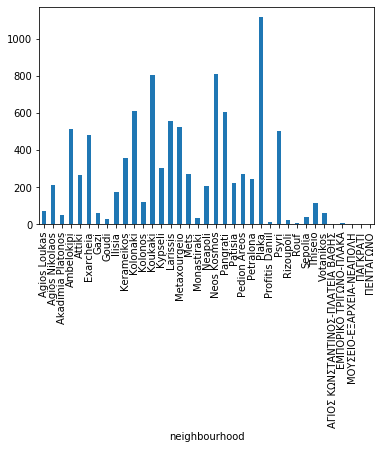

In [14]:
#6
graph = df.groupby(by='neighbourhood').size()
graph.plot.bar(y='Count',x='Neighbourhoods')

In [28]:
#7

temp = df[['room_type','neighbourhood']]
temp = temp.groupby(['neighbourhood','room_type']).size().sort_values(ascending=False)
#temp.to_csv("new.csv")

temp


neighbourhood                     room_type      
Plaka                             Entire home/apt    1021
Neos Kosmos                       Entire home/apt     747
Koukaki                           Entire home/apt     733
Kolonaki                          Entire home/apt     573
Pangrati                          Entire home/apt     552
                                                     ... 
Profitis Daniil                   Shared room           1
ΑΓΙΟΣ ΚΩΝΣΤΑΝΤΙΝΟΣ-ΠΛΑΤΕΙΑ ΒΑΘΗΣ  Entire home/apt       1
ΕΜΠΟΡΙΚΟ ΤΡΙΓΩΝΟ-ΠΛΑΚΑ            Private room          1
Agios Loukas                      Shared room           1
ΜΟΥΣΕΙΟ-ΕΞΑΡΧΕΙΑ-ΝΕΑΠΟΛΗ          Entire home/apt       1
Length: 85, dtype: int64

In [29]:
# 8

# df['price']
# df.replace(to_replace='price')
# print(len(normalValues))
# df.groupby(by='room_type',as_index=False)['price'].sum()
df.groupby(by='room_type',as_index=False).agg({'price':'mean'}).sort_values(['price'],ascending=False,ignore_index=True).style.hide_index()
# pd.Series(df['price'].sum(),index=['price'])

room_type,price
Private room,78.677536
Entire home/apt,62.677673
Shared room,33.425532
